# COMP5318 Week 11: Hidden Markov Models

Hidden Markov Models (HMMs) are **a class of probabilistic models** which allow us to **relate observed sequences of events to hidden events** which we consider as causal factors.

While useful in many spheres, HMMs and related probabilistic sequence models such as Conditional Random Fields (CRFs) have found **widespread use in Natual Language Processing**. Many NLP sequence labelling problems can be fit into this framework by considering words as observations and searching for a sequence of hidden tags, such as part-of-speech labels (noun, verb etc.). As elaborated at the end of today's tutorial, HMMs also have applications in bioinformatics.

Today, we aim to strengthen your understanding of the key algorithms underlying HMMs by implementing them and examining their use on some problems.

## 1. Setup
We begin by importing some packages used throughout the notebook.

In [1]:
import sys
import numpy as np
import pandas as pd
import sklearn

# Make the notebook's output stable across runs
np.random.seed(42)

## 2. Definitions

### Example:

Suppose Peter does one out of four activities each day: *painting*, *cleaning*, *shopping*, or *biking* → **Obervable Events**

We don’t know whether each day is sunny or rainy, but we believe the weather influences Peter’s choice of activity. → **The weather conditions are our hidden states.**

<img src="https://miro.medium.com/v2/resize:fit:1400/1*EI13dca4KqkqGQgijx0iGg.png" width=600>

Here are the components of our HMM:

- **Hidden States** (S): Sunny and Rainy.

- **Observables** (O): Painting, Cleaning, Shopping, and Biking.

- **Initial (Start) Probabilities** (π): The likelihood of the state at time t = 0. Let’s say the likelihood that it is Sunny on the first day is 0.6, while the likelihood that it is Rainy is 0.4. So,

- **Transition Probabilities** (A): These represent the probability of transitioning to another state given the current state. For example,
  + If the current state is Sunny, the probability that the next day is Sunny is 0.8, whereas the probability that the next day is Rainy is 0.2
  + If today is Rainy, the probability that tomorrow is Rainy is 0.6, while the probability that tomorrow is Sunny is 0.4.

- **Emission Probabilities** (E): These represent the probability of seeing a specific observable given a hidden state. For example:
  + The probability of Cleaning on a Sunny day is 0.1, whereas the probability of Cleaning on a Rainy day is 0.45.

### The markov assumption:
> **Next state only dependents on current state**


Let's introduce our first problem, which was originally devised by [Jason Eisner (2002)](https://www.cs.jhu.edu/~jason/papers/eisner.tnlp02.pdf).

> "You are climatologists in the year 2799, studying the history of global warming. You can’t find any records of Baltimore weather, but you do find my diary, in which I assiduously recorded how much ice cream I ate each day. What can you figure out from this about the weather that summer?"

In this case, we want to relate **the observations of Jason's ice-cream consumption with the weather hidden states**. To simplify, suppose the days were either Hot or Cold, and Jason ate only 0, 1, or 2 ice creams each day.

Before diving into our investigation, we need to recap the required components for an HMM.

- A set of N possible hidden states: $\pi=\pi_1, \pi_2, \dots, \pi_N$

- A sequence of M observations: $O = o_1 o_2 \dots o_M$

- A transition probability matrix, with probabilities $a_{ij}$ of moving from state i to state j: $A=a_{11} \dots a_{ij} \dots a_{NN}$, s.t. $\sum_{j=1}^n a_{ij} = 1$   $ \forall i$

- An initial probability distribution over the states: $A_0=a_1, a_2, \dots, a_N$

- An emission probability matrix, with conditional probabilities $P(o_j|\pi_i)$ of the observations for each state:
$E=e_{\pi_{i}}(o_j)$

Let's assume that it is possible to estimate the probability matrices from other sources of data such as weather trends and ice cream sales trends.

```
states = ('Hot', 'Cold')
```

```
observations = (0, 1, 2)
```

```
transition_probability = {
   'Hot' : {'Hot': 0.8, 'Cold': 0.2},
   'Cold' : {'Hot': 0.3, 'Cold': 0.7},
}
```

```
start_probability = {'Hot': 0.5, 'Cold': 0.5}
```

```
emission_probability = {
   'Hot' : {0: 0.1, 1: 0.2, 2: 0.7},
   'Cold' : {0: 0.7, 1: 0.2, 2: 0.1},
}
```

**Transition probabilities**

Suppose we have some intuition or evidence that if today is cold, tomorrow is likely to be cold, while if today is hot, tomorrow is probably hot. A transitions matrix encoding that might be:

In [2]:
transitions = np.array([[0.8, 0.2],
                        [0.3, 0.7]])

**Initial probabilities**

We also might suppose that we have an equal chance of beginning on a relatively hot or cold day.

In [3]:
initials = np.array([0.5, 0.5])

**Emission probabilities**

On cold days, it seems that Jason doesn't generally like to eat ice cream except for rare occasions, but on hot days Jason often likes to eat 2 ice creams. Our emission probability matrix might look a bit like the following, where the rows correspond to observations {0, 1, 2}, and the columns correspond to states {Hot, Cold}:

In [4]:
emissions = np.array([[0.1, 0.7],
                      [0.2, 0.2],
                      [0.7, 0.1]])

We can use the Pandas library to display these matrices in a more readable format:

In [5]:
# Create Pandas dataframes from arrays
df_transitions = pd.DataFrame(transitions, index=["fromHot", "fromCold"], columns=["toHot", "toCold"])
df_initials = pd.DataFrame(initials, index=["Hot", "Cold"], columns=["Initial Prob"])
df_emissions = pd.DataFrame(emissions, index=["0", "1", "2"], columns=["Hot", "Cold"])

display(df_transitions)
display(df_initials)
display(df_emissions)

,toHot,toCold
fromHot,0.8,0.2
fromCold,0.3,0.7


,Initial Prob
Hot,0.5
Cold,0.5


,Hot,Cold
0,0.1,0.7
1,0.2,0.2
2,0.7,0.1


We've now specified an HMM which we can use to investigate our problem! You will remember from the lecture that HMMs are often specified as a graph to aid our interpretation of the model.

**Question**

Draw a graph illustrating this HMM model.

#### Solution

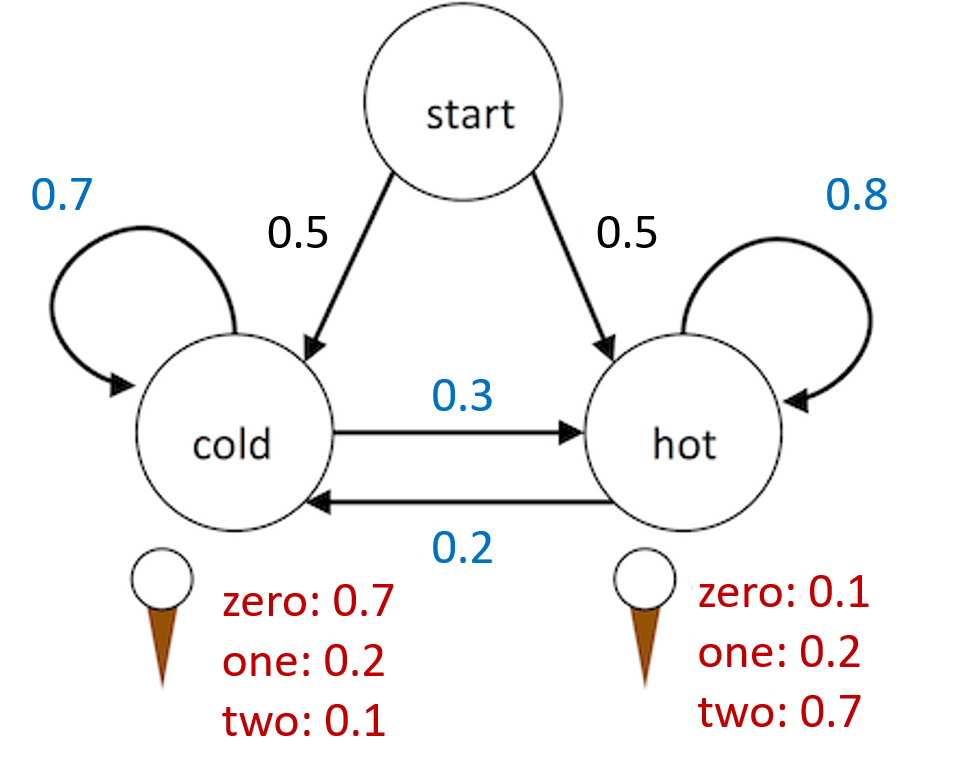

#### **Three Fundamental tasks of HMM**:


1. **Learning**: Given a set of training data, determine the parameters (specifically: the start, transition, and emission probabilities) of the HMM.
2. **Likelihood**: Given a fully trained HMM, determine the likelihood of a sequence of observed variables.
  -  E.g., Compute the likelihood of observing a sequence like [1, 0, 2, 1] (representing the number of ice creams Jason ate on different days).

3. **Decoding**: Given a fully trained HMM and a sequence of observed variables, determine the most likely sequence of hidden states.
  - E.g., Finding the most likely sequence of hidden states (weather conditions) that led to the observed sequence of ice creams consumed.

## **3. Evaluation**

Recall that HMMs are characterised by three fundamental problems. The first is evaluation, otherwise known as likelihood computation.

> Given an HMM $M$ and an observation sequence $X$, determine the probability of the observed sequence $P(X|M)$.

Recall from the lecture that this is easy to solve using the emission probabilites if we assume a particular set of hidden states. However, using this method we would have to **consider all possible sequences of states which could generate the observations**, which quickly becomes infeasible as the sequence length grows.

$P(2\ 0\  1|hot\  hot\  hot) = P(2|hot) \times P(0|hot) \times P(1|hot)$

$P(2\ 0\  1|hot\  hot\  cold) = P(2|hot) \times P(0|hot) \times P(1|cold)$

$P(2\ 0\  1|hot\  cold\  hot) = P(2|hot) \times P(0|cold) \times P(1|hot)$

...

**For an HMM with $N$ hidden states and an observation sequence of $T$ observations, there are $N^T$ possible hidden sequences.**

**If $N$ and $T$ are both large, $N^T$ is a very large number.**

Instead, we derived the forward algorithm, a **dynamic programming algorithm** which stores a table of intermediate values to make the computation of observation probabilities summed over all possible hidden state paths more efficient [$O(N^2M)$, using our notation from above].

The intermediate values it keeps are the forward probabilities:

$\begin{aligned} f_{k}(i) &=P\left(o_{1}, \cdots, o_{i}, \pi_{i}=k\right) \\ &=e_{k}\left(o_{i}\right) \sum_{j} f_{j}(i-1) a_{j k} \end{aligned}$

Recall the key steps of the algorithm from the lecture:

*Initialisation*: $f_{k}(0) = a_k * e_{\pi_{k}}(o_0)$

*Iteration*: $f_{k}(i)=\sum_{j} f_{j}(i-1) * a_{j k} * e_{k}\left(x_{i}\right) $

*Termination*: $P(o_1 o_2 \dots o_M)=\sum_{k} f_{k}(n)$

Let's implement the forward algorithm using numpy. Rather than explicitly do these calculations for each state, we use matrix multiplication to handle all the states at once. Carefully go through the implementation and see if you can find each step of the algorithm in the code.

#### **Forward Algorithm for Hidden Markov Models**

**Key concept:**
- *Probabilistic Summation*: It calculates the sum of the probabilities of all possible hidden state sequences that could produce the observed sequence.
- *Dynamic Programming*: It uses a recursive approach to efficiently calculate the probabilities of sequences up to each observation, storing these probabilities in a table to avoid redundant calculations.
- *Forward Probabilities*: For each step in the observed sequence and each state, it computes the probability of ending up in that state having seen the sequence up to that point.

##### **Inputs**
- **O**: An observation sequence `[o_1, o_2, ..., o_{M}]`
- **N**: Total number of states in the HMM

##### **Output**
- **Probability** of observing the sequence O given the model parameters

##### **Steps**

1. **Initialize forward probabilities:**
    ```
    For each state `k` from `1` to `N`:
      f_k(1) = initial_probability[k] * emission_probability[k][o_1]
    ```

2. **Compute forward probabilities for each observation in the sequence:**
    ```
    For each observation index `i` from `2` to `M`:
      For each state `k` from `1` to `N`:
        sum = 0
        For each previous state `j` from `1` to `N`:
          sum += f_j(i-1) * transition_probability[j][k]
        f_k(i) = sum * emission_probability[k][o_i]
    ```

3. **Calculate the total probability of the observation sequence:**
   ```
   total_probability = 0
   For each state `k` from `1` to `N`:
       total_probability += f_k(M)
   ```


#### **Implementation**

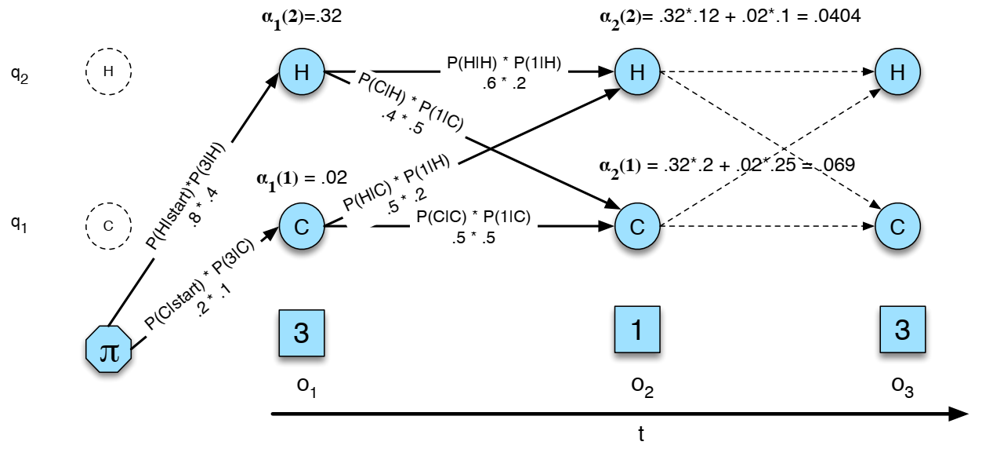

In [6]:
def forward(obs_seq, transitions, emissions, initials, verbose=False):
    """Given HMM parameters, find the probability of an observation sequence.

    Args:
      obs_seq: 1D numpy array containing a sequence of observations encoded as indices
      transitions: 2D square numpy array of transition probabilities between states
      emissions: 2D numpy array of shape (num_obs, num_states) containing emissions probabilities P(obs|state)
      initials: 1D numpy array of initial distribution over states
      verbose: If True, print output during computation

    Returns:
      Probability of observed sequence under the HMM model as a float.
    """

    seq_len = len(obs_seq)
    num_states = transitions.shape[0]

    # Intialise the array to hold forward values for each state at each timestep
    forward = np.zeros((seq_len, num_states))

    # Extract the emission probabilities for this particular obs_seq
    emissions_seq = emissions[obs_seq]

    # Set first forward scores depending on initial distribution and emission probs
    forward[0] = initials * emissions_seq[0]

    if verbose:
        print(f"Forward values at step 0: {forward[0]}\n")

    for step in range(1, seq_len):

        # Calculate forward values for this step for all states using matrix multiplications
        # The new forward values depend on forward values at previous step, transitions, and emissions
        forward[step] = np.sum(forward[step-1].reshape(-1, 1) * transitions * emissions_seq[step], axis=0)

        if verbose:
            print(f"Forward values at step {step}: {forward[step]}\n")

    # Sum over forward values at last timestep
    seq_prob = np.sum(forward[seq_len-1], axis=0)

    if verbose:
        print(f"Total probability of observed sequence: {seq_prob:.4g}")

    return seq_prob

Let's find the probability of a particular sequence of observations. We will run the forward algorithm with verbose output so we can track how the forward probabilities change throughout calculation.

In [7]:
# Calculate sequence probability, printing out intermediate values
obs_seq = np.array([2, 0, 2, 1, 2])
forward(obs_seq, transitions, emissions, initials, verbose=True)

Forward values at step 0: [0.35 0.05]

Forward values at step 1: [0.0295 0.0735]

Forward values at step 2: [0.031955 0.005735]

Forward values at step 3: [0.0054569 0.0020811]

Forward values at step 4: [0.0034929  0.00025482]

Total probability of observed sequence: 0.003748


0.0037477100000000005

We are now able to solve the evaluation problem with our HMM. For any observation sequence, we can figure out how likely it is. Let's see the results for a few more sequences!

In [8]:
# Print the probabilities of several sequences, rounded to 4 sig figs

print((f"Probability of sequence {[0, 0, 0, 0, 0]}: "
       f"{forward([0, 0, 0, 0, 0], transitions, emissions, initials):.4g}")
)

print((f"Probability of sequence {[1, 1, 1, 1, 1]}: "
       f"{forward([1, 1, 1, 1, 1], transitions, emissions, initials):.4g}")
)

print((f"Probability of sequence {[2, 2, 2, 2, 2]}: "
       f"{forward([2, 2, 2, 2, 2], transitions, emissions, initials):.4g}")
)

print((f"Probability of sequence {[0, 1, 1, 2, 2]}: "
       f"{forward([0, 1, 1, 2, 2], transitions, emissions, initials):.4g}")
)

print((f"Probability of sequence {[0, 1, 1, 2, 2, 2]}: "
       f"{forward([0, 1, 1, 2, 2, 2], transitions, emissions, initials):.4g}")
)

Probability of sequence [0, 0, 0, 0, 0]: 0.02398
Probability of sequence [1, 1, 1, 1, 1]: 0.00032
Probability of sequence [2, 2, 2, 2, 2]: 0.03962
Probability of sequence [0, 1, 1, 2, 2]: 0.003718
Probability of sequence [0, 1, 1, 2, 2, 2]: 0.002105


## **4. Decoding**

Another fundamental HMM task is decoding.

> Given an HMM $M$ and an observation sequence $X$, what is the most likely sequence of hidden states that generated sequence $X$?

Tasks such as part-of-speech tagging fit into this framework, where the observations are words and the hidden state we would like to know is the part-of-speech labels (think nouns, verbs etc.).

Recall from the lecture that this problem can be efficiently solved using the Viterbi program, a dynamic programming algorithm in similar spirit to the forward algorithm.

It uses intermediate Viterbi values:
$$V_{k}(i)=\max _{\pi_{1} \cdots \pi_{i-1}} P\left(\pi_{1}, \cdots, \pi_{i-1}, o_{1}, o_2, \cdots o_{i}, \pi_{i}=k\right)$$ which are the probabilities of the most likely sequence of states ending at state $\pi_i=k$.

As for the forward algorithm let's recall the steps from the lecture.

*Initialisation*: $V_{k}(0) = a_k * e_{\pi_{k}}(o_0)$

*Iteration*: $$
\begin{array}{l}
V_{j}(i)= \max _{k} [a_{k j} * V_{k}(i-1) * e_{j}\left(o_{i}\right)]\\
P t r_{j}(i)=\underset{k}{\operatorname{argmax}} [a_{k j} * V_{k}(i-1) * e_{j}\left(o_{i}\right)]
\end{array}
$$

*Termination*: $P(O, \pi^*)=\max _{k}V_{k}(M)$

This is the joint probability of the observations and best hidden state sequence. To find the best sequence, we can backtrack through our pointer variables we stored when taking maximums for the Viterbi score computations at each timestep.

Take a look at the implementation below and find each step of the algorithm.

#### **Viterbi Algorithm**

**Key concepts:**
- Calculates the maximum probability of the most likely sequence of hidden states, rather than summing probabilities.
- *Dynamic Programming*: Similar to the Forward Algorithm, it employs dynamic programming but focuses on finding the maximum probability path through the model's states.
- *Viterbi Path*: It computes, for each state and each step, the maximum probability path that ends in that state at that time, storing back pointers to reconstruct the path once the end of the sequence is reached.

##### **Input**:
- **O**: An observation sequence `[o_1, o_2, ..., o_{M}]`
- **N**: Total number of states in the HMM

##### **Output**:
- The most likely sequence of hidden states

##### **Steps**:

1. Initialize the matrices:
   ```
   V[1..N][1..M] <- 0 (Viterbi probabilities)
   Ptr[1..N][1..M] <- 0 (Back pointers)
   ```

2. Initialize the Viterbi probabilities for the first observation:
   ```
   For each state k from 1 to N:
       V[k][1] = initial_probability[k] * emission_probability[k][o_1]
       Ptr[k][1] = 0
   ```

3. Compute Viterbi probabilities for each subsequent observation:
   ```
   For each observation index i from 2 to M:
       For each state j from 1 to N:
           V[j][i] = max_k(V[k][i-1] * transition_probability[k][j]) * emission_probability[j][o_i]
           Ptr[j][i] = argmax_k(V[k][i-1] * transition_probability[k][j])
   ```

4. Termination:
   ```
   final_probability = max_k(V[k][M])
   last_state = argmax_k(V[k][M])
   ```

5. Backtrack to find the most likely sequence of states:
   ```
   best_path[M] = last_state
   For each i from M-1 to 1:
       best_path[i] = Ptr[best_path[i+1]][i+1]
  ```

Return `best_path`, `final_probability`


#### **Implementation**

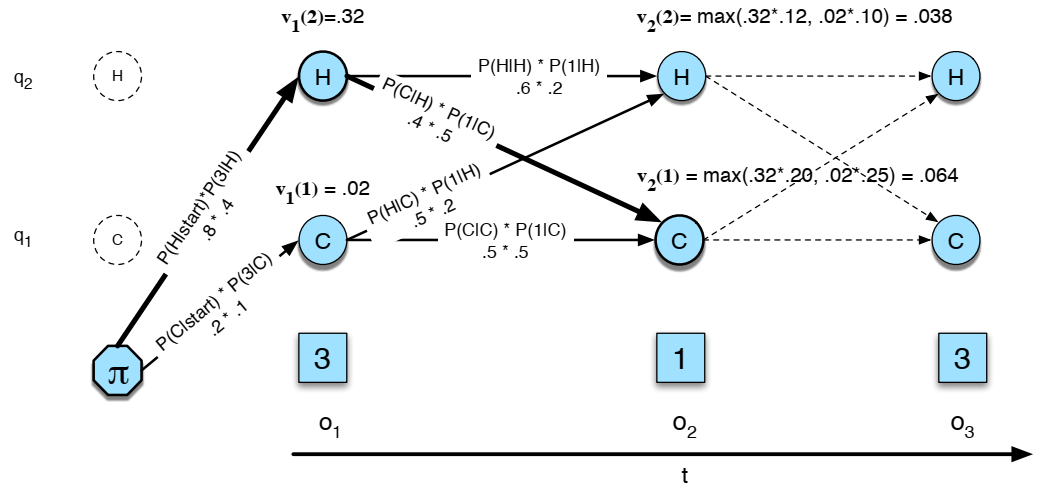

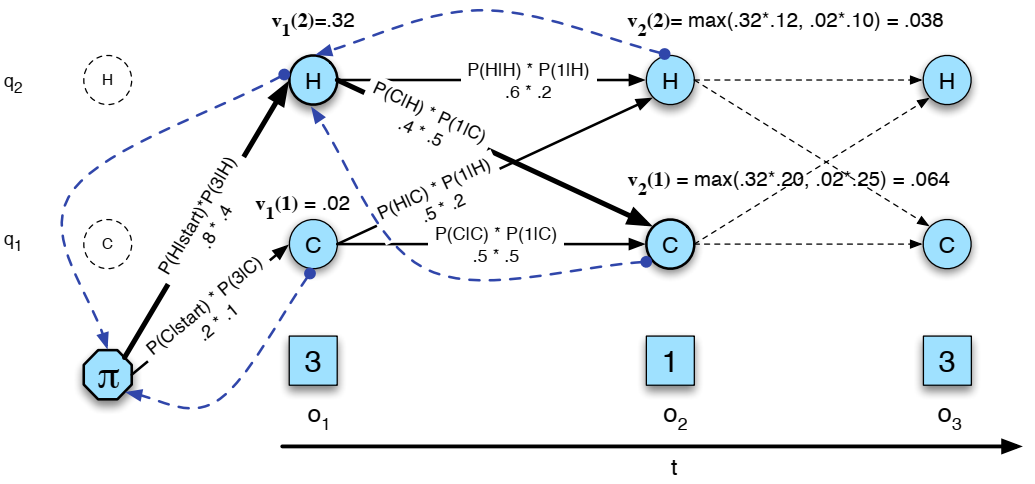

In [9]:
def viterbi(obs_seq, transitions, emissions, initials):
    """Given HMM parameters, find the state path that maximises likelihood of an observed sequence.

    Args:
      obs_seq: 1D numpy array containing a sequence of observations encoded as indices
      transitions: 2D square numpy array of transition probabilities between states
      emissions: 2D numpy array of shape (num_obs, num_states) containing emissions probabilities P(obs|state)
      initials: 1D numpy array of initial distribution over states

    Returns:
      Tuple of the state path found and associated Viterbi scores
    """

    seq_len = len(obs_seq)
    num_states = transitions.shape[0]

    # Initialise required arrays to store viterbi values
    path_states = np.zeros((seq_len, num_states))
    path_scores = np.zeros((seq_len, num_states))
    best_state_seq = np.zeros(seq_len, dtype=np.int64)

    # Extract the emission probabilities for this particular obs_seq
    emissions_seq = emissions[obs_seq]

    # Set first forward scores depending on initial distribution and emission probs
    path_scores[0] = initials * emissions_seq[0]

    for step in range(1, seq_len):

        # Generate candidate Viterbi scores for each state using matrix summations
        candidate_scores = path_scores[step-1].reshape(-1, 1)\
                           * transitions\
                           * emissions_seq[step]

        # Update Viterbi scores and paths by maximising over candidate scores
        path_scores[step] = np.max(candidate_scores, axis=0)
        path_states[step] = np.argmax(candidate_scores, axis=0)

    # Termination step: choose final state by max Viterbi score
    best_state_seq[seq_len-1] = np.argmax(path_scores[seq_len-1], axis=0)

    # Backtrack over the best path found by Viterbi
    for step in range(seq_len-1, 0, -1):
        next_state = best_state_seq[step]
        best_state_seq[step-1] = path_states[step, next_state]

    return best_state_seq, path_scores

Let's observe the results on a particular sequence of observations.

In [10]:
obs_seq = np.array([2, 0, 2, 1, 2])

# Use Viterbi to decode the observed sequence
states_seq, state_prob = viterbi(obs_seq, transitions, emissions, initials)

# Visualise the output
df = pd.DataFrame(state_prob.transpose(), index=["Hot", "Cold"])
state_names = ["Hot", "Cold"]
print([state_names[s] for s in states_seq])
df

['Hot', 'Hot', 'Hot', 'Hot', 'Hot']


,0,1,2,3,4
Hot,0.35,0.028,0.01568,0.002509,0.001405
Cold,0.05,0.049,0.00343,0.000627,0.000050


Note that despite the low probability of Jason eating zero ice creams on a hot day, the second day (index 1) is likely hot when taken in context with the rest of the sequence due to the relevant transition probabilities.

## 5. **Task - Detecting a Biased Die**

Suppose you have some inside information that a casino has been switching to a biased die during games. You wish to determine when they are using a fair die and when they are using the biased one to optimise your betting strategy.

Your source has disclosed that the games always begin with a fair die. For every roll after that, there is a 1/10 chance that the current die will be switched to the other kind (ie. switch fair die to biased die, or vice versa).

The fair die, as expected, has an equal 1/6 chance of rolling each number 1 to 6. The biased die rolls a 1 50% of the time, and each other number 2 through 6 comes up 10% of the time.

This problem can be modelled using an HMM. Your first task is to define the appropriate matrices for the HMM.

Armed with your HMM, suppose you observe the following sequence of 15 rolls at the casino:
[1, 5, 6, 2, 4, 6, 1, 3, 6, 2, 1, 1, 1, 4, 6]

- Determine the probability of this sequence of rolls given what we know about the possible use of a biased die. How does this compare to the sequence probability under a fair die ($(1/6)^n$)?


- Determine when the fair die and biased die were most likely being used.

Hint: remember that while the rolls are 1-6, our states are usually indexed from 0.

```
states = {fair, biased}

observations = {1,2,3,4,5,6}
```

In [11]:
transitions = np.array([[0.9, 0.1],
                        [0.1, 0.9]])

initials = np.array([1,0])

emissions = np.array([[1./6, 0.5],
                      [1./6, 0.1],
                      [1./6, 0.1],
                      [1./6, 0.1],
                      [1./6, 0.1],
                      [1./6, 0.1]])

obs_seq = [1, 5, 6, 2, 4, 6, 1, 3, 6, 2, 1, 1, 1, 4, 6]

obs_seq = [roll-1 for roll in obs_seq]

In [12]:
print(f"Probability under HMM: {forward(obs_seq, transitions, emissions, initials):.4g}")

Probability under HMM: 4.926e-12


In [13]:
dice_used, viterbi_scores = viterbi(obs_seq, transitions, emissions, initials)

In [14]:
print(["Fair" if x==0 else "Biased" for x in dice_used])

['Fair', 'Fair', 'Fair', 'Fair', 'Fair', 'Fair', 'Fair', 'Fair', 'Fair', 'Fair', 'Biased', 'Biased', 'Biased', 'Biased', 'Biased']


### Solution

```
states = {fair, biased}

observations = {1,2,3,4,5,6}
```

In [15]:
transitions = np.array([[0.9, 0.1],
                        [0.1, 0.9]])

initials = np.array([1, 0])

emissions = np.array([[1./6, 0.5],
                      [1./6, 0.1],
                      [1./6, 0.1],
                      [1./6, 0.1],
                      [1./6, 0.1],
                      [1./6, 0.1]])

obs_seq = [1, 5, 6, 2, 4, 6, 1, 3, 6, 2, 1, 1, 1, 4, 6]

# Subtract one from each roll to get the corresponding state index
obs_seq = [roll-1 for roll in obs_seq]

Calculate the probability of this sequence and compare the probability under fair die:

In [16]:
print(f"Probability under HMM: {forward(obs_seq, transitions, emissions, initials):.4g}")

print(f"Probability under fair die: {(1/6)**15:.4g}")

Probability under HMM: 4.926e-12
Probability under fair die: 2.127e-12


Predict when the dice is fair and biased using Viterbi:

In [17]:
dice_used, viterbi_scores = viterbi(obs_seq, transitions, emissions, initials)

# Print list with state names
print(["Fair" if x==0 else "Biased" for x in dice_used])

['Fair', 'Fair', 'Fair', 'Fair', 'Fair', 'Fair', 'Fair', 'Fair', 'Fair', 'Fair', 'Biased', 'Biased', 'Biased', 'Biased', 'Biased']


Under the HMM, Viterbi predicts that the sequence of several ones in a row was due to the biased die!

For your curiousity, the following code was used to generate this sequence. You might like to generate some other roll sequences by rerunning the code.

In [18]:
def roll_die(seq_len=1):
    """Return a sequence of rolls from a fair or biased die as defined in problem description above.

    Args:
        seq_len: how many rolls to perform

    Returns:
        A list of results from dice rolls and a list of which dice was used for each roll.
    """

    rolls = []
    dice_used = []

    # Initially the dice is unbiased
    biased = False

    for roll_num in range(seq_len):

        if biased:
            # Roll biased die
            roll = np.random.choice([1, 2, 3, 4, 5, 6], p=[0.5, 0.1, 0.1, 0.1, 0.1, 0.1])
        else:
            # Roll fair die
            roll = np.random.choice([1, 2, 3, 4, 5, 6], p=[1./6 for i in range(6)])

        rolls.append(roll)
        dice_used.append("Biased") if biased else dice_used.append("Fair")

        # Change to other die with 1/10 probability
        if np.random.random() < 0.1:
            biased = not biased

    return rolls, dice_used


### Application of this problem to bioinformatics
While they may seem simple, biased dice or fair casino problems are directly related to an application of HMMs in bioinformatics.

In DNA, a cystine (C) followed by a guanine (G) is called a CpG dinuleotide. These dinucleotides are less frequent than expected by random chance, except for in specific regions called CpG islands ([Wikipedia](https://en.wikipedia.org/wiki/CpG_site#CpG_islands)), where they are clustered. These regions are important to find because they are often associated with the start of a gene.

Given a genomic sequence, this detection problem can be modelled similarly to the biased dice problem, where the states are {non-island, CpG island} and the observations are the dinucleotides in the DNA. We can decode to determine when the sequence is in a CpG island.

[Wu et al. (2010)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2883304/) have utilised HMMs on this problem, and a more thorough explanation can be found [here](http://www.math.clemson.edu/~macaule/classes/f16_math4500/slides/f16_math4500_cpg-islands_handout.pdf).

## 6. Summary

In [ ]:
# Example of HMM matrices
transitions = np.array([[0.8, 0.2],
                        [0.3, 0.7]])

initials = np.array([0.5, 0.5])

emissions = np.array([[0.1, 0.7],
                      [0.2, 0.2],
                      [0.7, 0.1]])

# Solve the evaluation/likelihood problem using the forward algorithm
seq_prob = forward(obs_seq, transitions, emissions, initials, verbose=True)

# Solve the decoding problem using the Viterbi algorithm
states_seq, viterbi_scores = viterbi(obs_seq, transitions, emissions, initials)

## Acknowledgements

- The ice cream example was adapted from:

*Eisner, J. (2002, July). An interactive spreadsheet for teaching the forward-backward algorithm. In Proceedings of the ACL-02 Workshop on Effective tools and methodologies for teaching natural language processing and computational linguistics (pp. 10-18). Link: https://www.cs.jhu.edu/~jason/papers/eisner.tnlp02.pdf*

- The biased coin/die problem is widespread in HMM sources. The Fair Bet Casino problem in the following book was consulted:

*Neil C. Jones & Pavel A. Pevzner 2004, An Introduction to Bioinformatics Algorithms, Computational Molecular Biology, The MIT Press, Cambridge, MA*

- For the information on HMMs in bioinformatics:

*Wu, H., Caffo, B., Jaffee, H. A., Irizarry, R. A., & Feinberg, A. P. (2010). Redefining CpG islands using hidden Markov models. Biostatistics (Oxford, England), 11(3), 499–514. https://doi.org/10.1093/biostatistics/kxq005*

http://www.math.clemson.edu/~macaule/classes/f16_math4500/slides/f16_math4500_cpg-islands_handout.pdf
